## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOMSFY0/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOMSFY0/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteOMSFY0/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
dataset

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"The concept for Sarafina appears to be a sound one, that is aside from the musical perspective. It attempts to combine upbeat African music with a story describing the atrocious conditions and atmosphere that black people were forced to endure at the time the film was set. The contradictions of each of the two elements are too glaring and the film never justifies such rapid shifts between jubilation and terror. Had it simply been a drama reflecting these conditions it may have been a good film, however the scenes of school children being shot down by soldiers don't exactly sit well next to the songs. <br /><br />Aside from the poor premise the acting isn't the best either, Goldberg gives a mediocre performance as does the remainder of the cast. Overall a disappointment.<br /><br />3/10"
 b'The biggest mystery of Veronica Mars is not one that she had to tackle on screen.<br /><br />Rather, the mystery is why this perennial ratings disappointment is still on the air. This week

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2,   1,  16, ...,   0,   0,   0],
       [  2,   1, 755, ...,   0,   0,   0],
       [ 10, 364,  56, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"The concept for Sarafina appears to be a sound one, that is aside from the musical perspective. It attempts to combine upbeat African music with a story describing the atrocious conditions and atmosphere that black people were forced to endure at the time the film was set. The contradictions of each of the two elements are too glaring and the film never justifies such rapid shifts between jubilation and terror. Had it simply been a drama reflecting these conditions it may have been a good film, however the scenes of school children being shot down by soldiers don't exactly sit well next to the songs. <br /><br />Aside from the poor premise the acting isn't the best either, Goldberg gives a mediocre performance as does the remainder of the cast. Overall a disappointment.<br /><br />3/10"
Round-trip:  the [UNK] for [UNK] appears to be a sound one that is [UNK] from the musical [UNK] it attempts to [UNK] [UNK] [UNK] music with a story [UNK] the [UNK] [UNK] and atmosphere that

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00023569]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00023569]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 110s 254ms/step - loss: 0.6363 - accuracy: 0.5758 - val_loss: 0.4751 - val_accuracy: 0.7563
Epoch 2/10
391/391 [==============================] - 92s 232ms/step - loss: 0.3879 - accuracy: 0.8222 - val_loss: 0.3933 - val_accuracy: 0.8500
Epoch 3/10
391/391 [==============================] - 91s 231ms/step - loss: 0.3379 - accuracy: 0.8518 - val_loss: 0.3380 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 91s 231ms/step - loss: 0.3203 - accuracy: 0.8602 - val_loss: 0.3319 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 93s 235ms/step - loss: 0.3150 - accuracy: 0.8628 - val_loss: 0.3308 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 91s 231ms/step - loss: 0.3123 - accuracy: 0.8646 - val_loss: 0.3409 - val_accuracy: 0.8479
Epoch 7/10
391/391 [==============================] - 95s 241ms/step - loss: 0.3038 - accuracy: 0.8711 - val_loss: 0.3226 - val_a

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 47s 120ms/step - loss: 0.3184 - accuracy: 0.8511
Test Loss: 0.31836116313934326
Test Accuracy: 0.8511199951171875


(0.0, 0.6532087907195091)

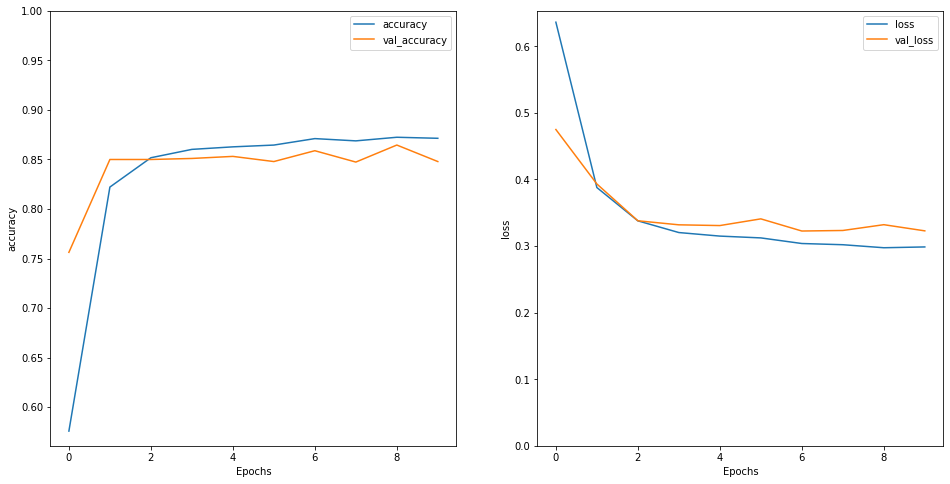

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [44]:
sample_text = ("SCheiß Film schmeiß weg des Ding")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.06797532]


In [40]:
if predictions >= 0.0: 
  print("Das Review ist positiv")
else: 
  print("Das Review ist negativ")

Das Review ist positiv


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [43]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 184s 467ms/step - loss: 0.6263 - accuracy: 0.5865 - val_loss: 0.4371 - val_accuracy: 0.7891
Epoch 2/10
391/391 [==============================] - 168s 426ms/step - loss: 0.3829 - accuracy: 0.8329 - val_loss: 0.3542 - val_accuracy: 0.8359
Epoch 3/10
391/391 [==============================] - 167s 425ms/step - loss: 0.3427 - accuracy: 0.8568 - val_loss: 0.3342 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 167s 424ms/step - loss: 0.3226 - accuracy: 0.8637 - val_loss: 0.3265 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 166s 422ms/step - loss: 0.3195 - accuracy: 0.8648 - val_loss: 0.3324 - val_accuracy: 0.8500
Epoch 6/10
391/391 [==============================] - 167s 424ms/step - loss: 0.3117 - accuracy: 0.8698 - val_loss: 0.3202 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 169s 431ms/step - loss: 0.3066 - accuracy: 0.8702 - val_loss: 0.3194 -

In [45]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 82s 209ms/step - loss: 0.3181 - accuracy: 0.8645
Test Loss: 0.31809571385383606
Test Accuracy: 0.8645200133323669


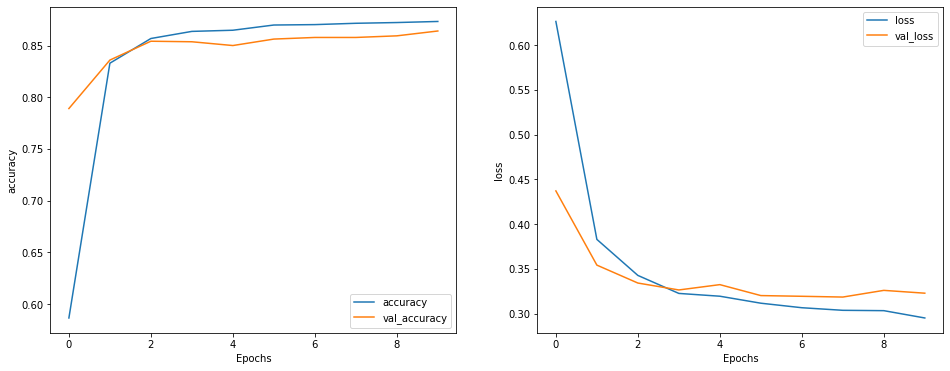

In [47]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [63]:
# predict on a sample text without padding.

sample_text = ("I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.")
predictions = model.predict(np.array([sample_text]))
print(predictions)
if predictions >= 0.0: 
  print("Das Review ist positiv")
else: 
  print("Das Review ist negativ")

[[2.5815213]]
Das Review ist positiv


In [67]:
sample_text = ("Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.")
predictions = model.predict(np.array([sample_text]))
print(predictions)
if predictions >= 0.0: 
  print("Das Review ist positiv")
else: 
  print("Das Review ist negativ")

[[-0.4801603]]
Das Review ist negativ


In [69]:
model.save("predictions")

INFO:tensorflow:Assets written to: predictions/assets


INFO:tensorflow:Assets written to: predictions/assets


In [70]:
SAVE =tf.keras.models.load_model("predictions")

ValueError: ignored